<h1>This notebook will be used for testing new ideas and confirm learnings<h1>

<h2>1. Load Data</h2>

In [ ]:
#the original pipeline
# 1. run_news.py
# 2. run_daily.py
# 3. train_pymc.py
# 4. eval_model.py
# 5. score_today.py

In [12]:
TICKERS = ["AMZN", "META"]  # add others if yfinance resolves them
MARKET = "SPY"

In [3]:
import os
from sqlalchemy import create_engine, text
from sqlalchemy.engine import Engine
from src.store.db import get_engine, init_tables

In [6]:
DATA_DIR = "./data"
os.makedirs(DATA_DIR, exist_ok=True)
print("The data directory made with abspath in absolute way is: ", DATA_DIR)
DEFAULT_SQLITE_PATH = os.path.join(DATA_DIR, "finance_test.db")
DEFAULT_DB_URL = f"sqlite:///{DEFAULT_SQLITE_PATH}"

The data directory made with abspath in absolute way is:  ./data


In [7]:
# Initialize the database, the engine needs no pass, it actually has a default url
# this will help wtih local vs cloud deployment, as the url can be set with env variable, and the code will work without change
engine = get_engine()
init_tables(engine)

In [9]:
from src.ingest.macro_fred import build_macro_frame
# from dotenv import load_dotenv
# load_dotenv()
start="2018-01-01"
end="2026-01-01"
macro = build_macro_frame(start, end)

In [10]:
macro.head(10)

,dt,dgs10,dgs2,curve_slope,fedfunds,bamlh0a0hym2,bamlc0a0cm,credit_spread
0,2018-01-01,NaN,NaN,NaN,1.33,NaN,NaN,NaN
1,2018-01-02,2.46,1.92,0.54,1.42,3.55,0.98,2.57
2,2018-01-03,2.44,1.94,0.50,1.42,3.48,0.99,2.49
3,2018-01-04,2.46,1.96,0.50,1.42,3.40,0.98,2.42
4,2018-01-05,2.47,1.96,0.51,1.42,3.36,0.98,2.38
5,2018-01-06,2.47,1.96,0.51,1.42,3.36,0.98,2.38
6,2018-01-07,2.47,1.96,0.51,1.42,3.36,0.98,2.38
7,2018-01-08,2.49,1.96,0.53,1.42,3.35,0.97,2.38
8,2018-01-09,2.55,1.98,0.57,1.42,3.33,0.96,2.37
9,2018-01-10,2.55,1.98,0.57,1.42,3.42,0.95,2.47


In [15]:
from src.ingest.prices_yf import download_prices
import pandas as pd

frames = []
for t in [MARKET] + TICKERS:
    df = download_prices(t, start, end)
    frames.append(df)
prices = pd.concat(frames, ignore_index=True)
prices.tail(10)

Price,ticker,dt,close,volume
6023,META,2025-12-17,649.500000,15598500
6024,META,2025-12-18,664.450012,20260300
6025,META,2025-12-19,658.770020,49977100
6026,META,2025-12-22,661.500000,15659400
6027,META,2025-12-23,664.940002,8486800
6028,META,2025-12-24,667.549988,5627500
6029,META,2025-12-26,663.289978,7133800
6030,META,2025-12-29,658.690002,8506500
6031,META,2025-12-30,665.950012,9187500
6032,META,2025-12-31,660.090027,7940400


In [16]:
prices_tbl = prices[["ticker", "dt", "close", "volume"]].copy()
macro_tbl = macro.copy()

In [17]:
# fetch fundamentals is a bit vague so I will do it with surgical breakdown
import yfinance as yf
import datetime as dt
import time

FIELDS = {
    "marketCap": "market_cap",
    "trailingPE": "trailing_pe",
    "priceToBook": "price_to_book",
    "profitMargins": "profit_margins",
    "operatingMargins": "operating_margins",
    "returnOnEquity": "return_on_equity",
}

asof = dt.date.today().strftime("%Y-%m-%d")
ticker = TICKERS[0]
tk = yf.Ticker(ticker)
info = tk.info  # network call + parse
print(tk.info)
row = {"ticker": ticker, "asof": asof}
for k, outk in FIELDS.items():
    v = info.get(k, None)
    # coerce to float where possible
    try:
        row[outk] = None if v is None else float(v)
    except Exception:
        row[outk] = None
print(row)

{'address1': '410 Terry Avenue North', 'city': 'Seattle', 'state': 'WA', 'zip': '98109-5210', 'country': 'United States', 'phone': '206 266 1000', 'website': 'https://www.amazon.com', 'industry': 'Internet Retail', 'industryKey': 'internet-retail', 'industryDisp': 'Internet Retail', 'sector': 'Consumer Cyclical', 'sectorKey': 'consumer-cyclical', 'sectorDisp': 'Consumer Cyclical', 'longBusinessSummary': "Amazon.com, Inc. engages in the retail sale of consumer products, advertising, and subscriptions service through online and physical stores in North America and internationally. The company operates through three segments: North America, International, and Amazon Web Services (AWS). It also manufactures and sells electronic devices, including Kindle, fire tablets, fire TVs, echo, ring, blink, and eero; and develops and produces media content. In addition, the company offers programs that enable sellers to sell their products in its stores; and programs that allow authors, independent p

In [18]:
from src.ingest.news_newsapi import fetch_news_for_tickers
import datetime as dt


today = dt.date.today()
date_to = today.strftime("%Y-%m-%d")
date_from = (today - dt.timedelta(days=7)).strftime("%Y-%m-%d")

TICKER_TO_NAME = {
    "GOOG": "Alphabet",
}

news = fetch_news_for_tickers(TICKERS, TICKER_TO_NAME, date_from=date_from, date_to=date_to, max_pages=5)
news.head(10)

✗ news AMZN: NewsAPI error 426: {"status":"error","code":"maximumResultsReached","message":"You have requested too many results. Developer accounts are limited to a max of 100 results. You are trying to request results 100 to 200. Please upgrade to a paid plan if you need more results."}
✓ news META: 98 articles


,published_at,dt,source,title,description,url,content_hash,ticker
0,2026-02-07T16:12:17Z,2026-02-07,Yahoo Entertainment,JOYY Inc. (JOYY): A Bull Case Theory,We came across a bullish thesis on JOYY Inc. o...,https://finance.yahoo.com/news/joyy-inc-joyy-b...,08fdc80275cb213aa49a171df366184cb88b56fb,META
1,2026-02-07T16:00:48Z,2026-02-07,CBS Sports,UFC Fight Night on Paramount+: Where to watch ...,Complete schedule and viewing information you ...,https://www.cbssports.com/ufc/news/ufc-fight-n...,e7d880e08f06dfd3d5767f12bdfe211cc43b119f,META
2,2026-02-07T16:00:32Z,2026-02-07,Kevinmd.com,Why progression independent of relapse activit...,"For too long, multiple sclerosis (MS) has been...",https://kevinmd.com/2026/02/why-progression-in...,3e4cb526e139aa7166d12a69bbafc791aa01de53,META
3,2026-02-07T16:00:00Z,2026-02-07,Yahoo Entertainment,UFC Vegas 113 predictions,Bantamweights headline at the newly re-named M...,https://consent.yahoo.com/v2/collectConsent?se...,f853da8ac43d86edc81687c2e4b6bb9906e168f7,META
4,2026-02-07T15:56:20Z,2026-02-07,Github.com,Show HN: The Codeverse Hub Linux,"Hi HN!, So, We are working on an open source L...",https://github.com/TheCodeVerseHub/CodeVerseLi...,27cc6362ce0d613ee3368f191cd302f856efea3a,META
5,2026-02-07T15:53:48Z,2026-02-07,Theflightdeal.com,United: Chicago – Singapore. $790 (Basic Econo...,A good sale to SingaporeUnited's $990 fare is ...,https://www.theflightdeal.com/2026/02/07/unite...,680e513e8119eda4594d876d8f5cfb16b037d425,META
6,2026-02-07T15:52:10Z,2026-02-07,Wordpress.org,Ticket #64613 (Add HTTP header declaring theme...,Summary\n\nWordPress should send a machine-rea...,https://core.trac.wordpress.org/ticket/64613,f5426b09933f6c9373a205cdd41f58d302761709,META
7,2026-02-07T15:43:59Z,2026-02-07,CNBC,Nearly a thousand Google workers sign letter u...,Hundreds of Google workers signed an open lett...,https://www.cnbc.com/2026/02/07/nearly-a-thous...,150b1493a55a4090f0f47a66dc018e784666aae7,META
8,2026-02-07T15:36:00Z,2026-02-07,Brettterpstra.com,Pandoc-style filters for Apex,In my quest to make Apex as complete as possib...,https://brettterpstra.com/2026/02/07/pandoc-st...,a98046b718fa41cdeacbfc0dc9e1baa550e5ca45,META
9,2026-02-07T15:32:25Z,2026-02-07,Slashdot.org,Better Dirt Cheap AI Growth Buy: Meta vs Micro...,Better Dirt Cheap AI Growth Buy: Meta vs Micro...,https://slashdot.org/firehose.pl?op=view&amp;i...,45024ebc3bd7d12ab4e28f570d895af5e1d83f0d,META


In [19]:
news.iloc[0]["description"]

'We came across a bullish thesis on JOYY Inc. on Triple S Special Situations Investing’s Substack by TripleS Special Situations. In this article, we will...'

<h2>2. Train model</h2> 

In [20]:
df = pd.read_parquet("data/model_frame.parquet")
df = df[df["dt"] >= "2025-01-01"].copy()

In [23]:
df.describe()

,ret_1d,beta_mkt,log_mktcap,value_z,mom_12_1,vol_20d,illiq_amihud,quality_z,macro_sens,credit_sens,news_sent_7d
count,9462.000000,9.462000e+03,9.462000e+03,9.462000e+03,9.462000e+03,9.462000e+03,9.462000e+03,9.462000e+03,9462.000000,9.462000e+03,9462.0
mean,0.000741,6.007548e-18,4.205284e-17,9.612077e-17,6.007548e-18,3.003774e-18,-3.003774e-17,-2.403019e-17,0.000001,-3.344045e-07,0.0
std,0.029838,9.868065e-01,9.868065e-01,8.272139e-01,9.868065e-01,9.868065e-01,9.766959e-01,9.733800e-01,0.000014,4.467260e-05,0.0
min,-0.297976,-3.368727e+00,-1.830276e+00,-2.546261e+00,-1.656061e+00,-2.353106e+00,-5.637106e-01,-2.195330e+00,-0.000056,-1.110223e-04,0.0
25%,-0.012302,-6.896711e-01,-6.439738e-01,-2.835775e-01,-4.673669e-01,-6.398188e-01,-4.280951e-01,-6.965293e-01,0.000000,0.000000e+00,0.0
50%,0.000852,-8.780833e-02,3.121828e-02,0.000000e+00,-1.905402e-01,-2.051768e-01,-3.285828e-01,-2.344954e-02,0.000000,0.000000e+00,0.0
75%,0.013909,5.386836e-01,5.737982e-01,3.581980e-01,1.842915e-01,4.562796e-01,-3.493411e-02,7.763018e-01,0.000000,0.000000e+00,0.0
max,0.379584,3.602075e+00,1.825581e+00,1.800700e+00,5.682779e+00,5.277801e+00,5.384631e+00,1.901649e+00,0.000111,1.110223e-04,0.0


In [24]:
df["ticker"]

1509     AAPL
1510     AAPL
1511     AAPL
1512     AAPL
1513     AAPL
         ... 
59020      ZS
59021      ZS
59022      ZS
59023      ZS
59024      ZS
Name: ticker, Length: 9462, dtype: object

In [25]:
keep = ["AMZN", "META"]
df = df[df["ticker"].isin(keep)].copy()

In [26]:
from src.train_pymc import fit_model
model, idata = fit_model(df)

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install gxx`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
d:\Projects\.venv\Lib\site-packages\arviz\__init__.py:50: FutureWarning: 
ArviZ is undergoing a major refactor to improve flexibility and extensibility while maintaining a user-friendly interface.
Some upcoming changes may be backward incompatible.
For details and migration guidance, visit: https://python.arviz.org/en/latest/user_guide/migration_guide.html
  warn(


d:\Projects\.venv\Lib\site-packages\rich\live.py:256: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Finished [100%]: Average Loss = -799.43
Sampling: [y]


d:\Projects\.venv\Lib\site-packages\rich\live.py:256: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

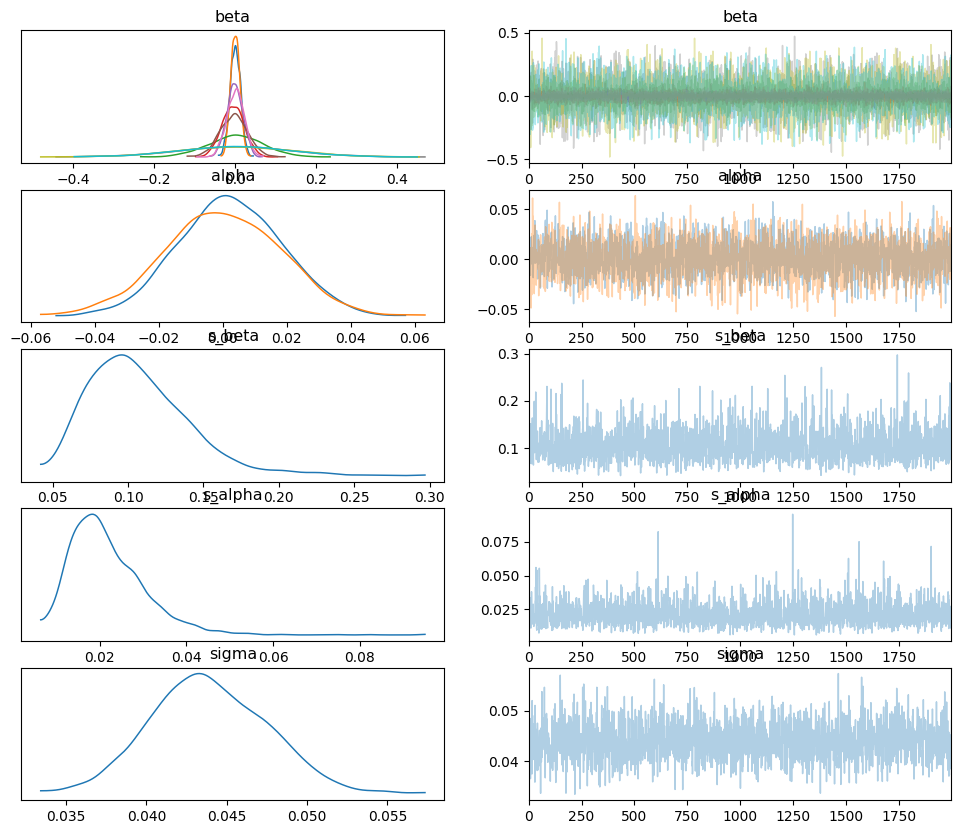

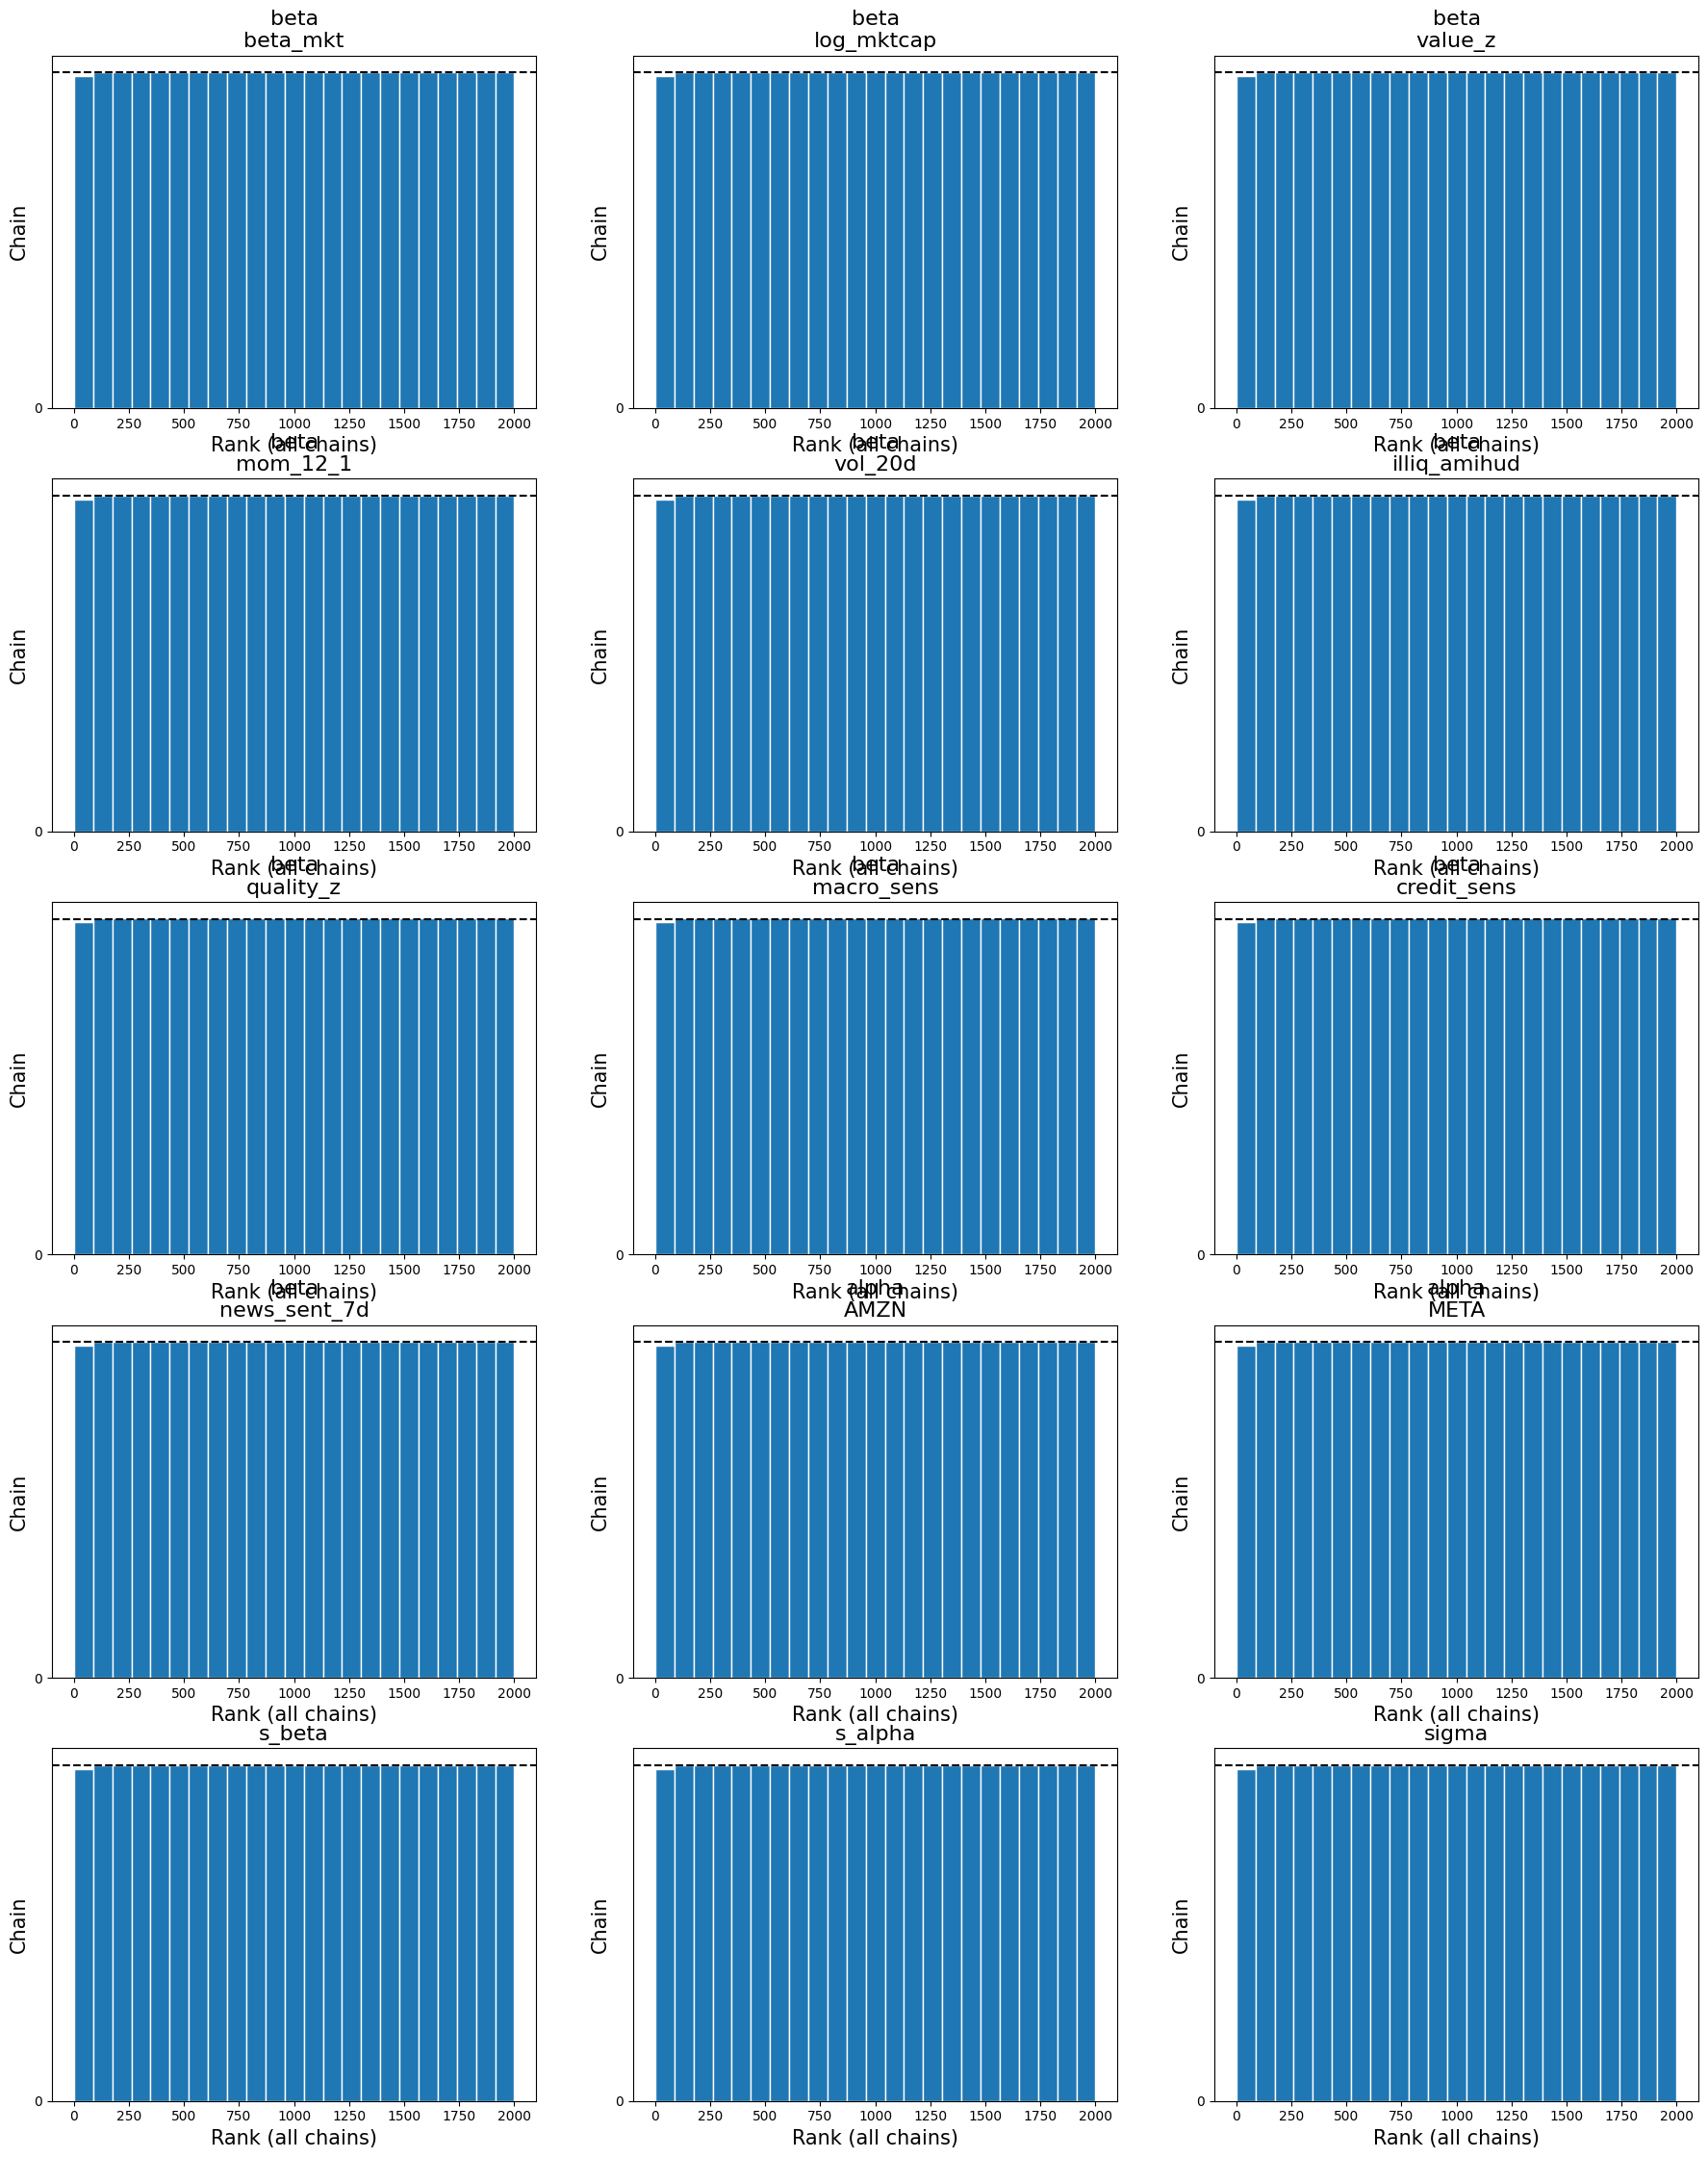

d:\Projects\.venv\Lib\site-packages\arviz\utils.py:146: UserWarning: Items starting with ~: ['log_likelihood'] have not been found and will be ignored
  warnings.warn(
arviz - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)


                     mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
beta[beta_mkt]      0.001  0.013  -0.025    0.024      0.000    0.000   
beta[log_mktcap]    0.001  0.011  -0.019    0.022      0.000    0.000   
beta[value_z]       0.002  0.067  -0.126    0.126      0.002    0.001   
beta[mom_12_1]     -0.004  0.027  -0.054    0.048      0.001    0.000   
beta[vol_20d]      -0.000  0.019  -0.034    0.038      0.000    0.000   
beta[illiq_amihud] -0.003  0.034  -0.066    0.063      0.001    0.001   
beta[quality_z]     0.002  0.021  -0.040    0.039      0.000    0.000   
beta[macro_sens]    0.001  0.141  -0.270    0.268      0.003    0.002   
beta[credit_sens]   0.002  0.142  -0.268    0.260      0.003    0.002   
beta[news_sent_7d]  0.001  0.137  -0.249    0.265      0.003    0.002   
alpha[AMZN]         0.002  0.016  -0.029    0.031      0.000    0.000   
alpha[META]        -0.000  0.018  -0.037    0.032      0.000    0.000   
s_beta              0.107  0.033   0.049    0.164  

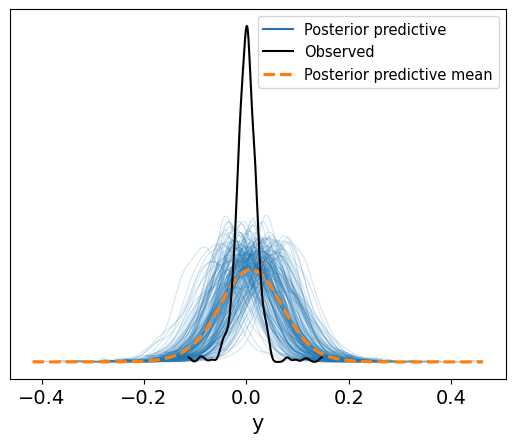

TypeError: log likelihood not found in inference data object

In [27]:
import arviz as az
import matplotlib.pyplot as plt

az.plot_trace(idata, compact=True); plt.show()
az.plot_rank(idata); plt.show()
print(az.summary(idata, var_names=["~log_likelihood"], round_to=3))

az.plot_ppc(idata, num_pp_samples=200); plt.show()

print("LOO:", az.loo(idata))
print("WAIC:", az.waic(idata))
